# Authors:
 - Akshat Mathur: PGID: 12010030
 - Sandipto Sanyal: PGID: 12010004
 - Shivaji Paleti: PGID: 12010072
 - Sidharth Gupta: PGID: 12010028
 - Sushmita Sahu: PGID: 12010027

# Project description
A brand-new professional training platform which will provide on demand, at home online video courses from thousands of experts in domains like IT, Photography, Music etc.
<br><br>
During the time of Covid, where people can’t physically attend classes and have a lot of time at hand to learn new skills or develop their existing talents and technologies. 
<br><br>
A faster, cheaper and more efficient way to reinvent  yourself
<br><br>
To perform this we have gathered data from https://www.udemy.com/ - an online learning portal so that we can understand which courses are mostly liked by students to build a recommendation engine and also for deciding the optimal prices which will be lesser burden for students to start their journeys in their onw field of interest.

# Requirements
Used Chrome driver for version Chrome version 83.<br>
For other chrome versions Download the related driver from: https://chromedriver.chromium.org/downloads

# Packages required
Uncomment and run if not the below packages are installed

In [1]:
#!pip install selenium
#!pip install plotnine
#!pip install beautifulsoup4
#!pip install pandas

# Import libraries

In [2]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import pandas as pd
from selenium.common import exceptions
import warnings
from plotnine import *

# User configurable variables
search_criteria and pages_to_scan are user configurable. They denote the course names and number of pages to scan for each course name

In [3]:
search_criteria = ['data science','photography', 'music', 'aws']
pages_to_scan = 2

# Launch the chrome browser

In [4]:
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument("--test-type")
locationOfWebdriver = "./chromedriver_win32/chromedriver.exe"

driver = webdriver.Chrome(locationOfWebdriver)

# Visit Udemy

In [5]:
driver.get('https://www.udemy.com/')
time.sleep(5)

# Search for courses through the search bar

In [6]:
def search_the_course(search_criteria: str):
    '''
    Run the website actions like scrolling to load the price tags
    '''
    def find_the_course_search_box():
        '''
        Target the search box using native Javascript and interact with it.
        Highlevel selenium API was not able to interact with the searchbox
        '''
        course_search_box = driver.find_element_by_xpath('//input[@placeholder="Search for anything" \
                                                          ]')
        # selenium highlevel API was not able to interact with the search box
        # so went into javascript level to
        driver.execute_script("arguments[0].value='{}';".format(search_criteria), 
                              course_search_box
                             )
        course_search_box.submit()
        
    # Now do a new search for the course in search bar
    course_to_search = search_criteria
    find_the_course_search_box()
    time.sleep(3)
    

# Scroll the page
Udemy does a lazy loading of course headers. Thus we scroll the page before parsing the XML.

In [7]:
def scroll_the_page():
    # scroll to the bottom of the page to load the price tags else they are kept hidden.
    # This is dynamically generated on scrolling to the bottom
    scroll_step = 250
    max_scroll_limit = 5500
    for scroll in range(500,max_scroll_limit, scroll_step):
        driver.execute_script("window.scrollTo(0, {})".format(scroll))
        # at last scroll to the bottom of the page
        if scroll + scroll_step >= max_scroll_limit:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        # give sleep time to load the prices
        time.sleep(2)

# Go to the next page
Below we define a method to go to the next page

In [8]:
def go_to_next_page():
    print('going to next page...')
    next_button = driver.find_element_by_xpath('//a[@data-page="+1"]')
    next_button.click()
    time.sleep(2)

# Loop with all the search criteria and the individual individual whole page to extract course related information
Go to the automated chrome browser to view how selenium is putting the search criteria one by one

In [9]:
data = {'search_criteria':[],
        'course_name':[],
        'course_description':[],
        'rating':[],
        'no_of_reviews':[],
        'duration':[],
        'lectures':[],
        'levels':[],
        'badge': [],
        'original_price':[],
        'discounted_price':[],
       }
for search in search_criteria:
    print('\n----------------------------------------\nSearch criteria:{}'.format(search))
    # run the website scrolling actions
    search_the_course(search)
    for page in range(1,pages_to_scan+1):
        # scroll the page to load the prices
        scroll_the_page()
        print('URL scraping: {}'.format(driver.current_url))
        # get the page xml
        soup = BeautifulSoup(driver.page_source, 'lxml')
        # list the courses
        courses = soup.find_all('div',class_='course-card--main-content--3xEIw course-card--has-price-text--1Ikr0')
        print('Number of courses found on page {}: {}'.format(page, len(courses)))
        for course in courses:
            try: 
                data['search_criteria'].append(search)
            except: 
                data['search_criteria'].append(None)
            try:
                data['course_name'].append(course.div.get_text()); 
            except: 
                data['course_name'].append(None)
            try: 
                data['course_description'].append(course.p.get_text()); 
            except: data['course_description'].append(None)
            try: 
                data['rating'].append(float(course.find('div',class_='course-card--row--1OMjg').span.find_all('span')[1].get_text())); 
            except: 
                data['rating'].append(None)
            try: 
                data['no_of_reviews'].append(course.find('div',class_='course-card--row--1OMjg').find_all('span')[-1].get_text()); 
            except: 
                data['no_of_reviews'].append(None)
            try: 
                data['duration'].append(course.find_all('div')[3].find_all('span')[0].get_text());
            except: 
                data['duration'].append(None)
            try: 
                data['lectures'].append(course.find_all('div')[3].find_all('span')[1].get_text()); 
            except: 
                data['lectures'].append(None)
            try:
                data['levels'].append(course.find_all('div')[3].find_all('span')[2].get_text()); 
            except: 
                data['levels'].append(None)
            try: 
                data['badge'].append(None) # couldn't extract this one will see later
            except:
                data['badge'].append(None)
            try:
                data['discounted_price'].append(float(re.sub('\u20B9|\,','',course.find('div',attrs={'data-purpose':"price-text-container"}).find_all('div')[0].find_all('span')[1].span.get_text()))); 
            except: data['discounted_price'].append(None)
            try: 
                data['original_price'].append(float(re.sub('\u20B9|\,','',course.find('div',attrs={'data-purpose':"original-price-container"}).find_all('div')[0].find_all('span')[1].span.get_text()))); 
            except: 
                data['original_price'].append(None)
        try:
            # visit next page
            go_to_next_page()
        except exceptions.ElementClickInterceptedException:
            try:
                go_to_next_page()
            except exceptions.ElementClickInterceptedException:
                try:
                    go_to_next_page()
                except Exception as e:
                    warnings.warn("Warning........... Couldn\'t navigate to next page")
                    pass
print('Search process ended')


----------------------------------------
Search criteria:data science
URL scraping: https://www.udemy.com/courses/search/?q=data+science
Number of courses found on page 1: 28
going to next page...
URL scraping: https://www.udemy.com/courses/search/?p=2&q=data+science
Number of courses found on page 2: 28
going to next page...

----------------------------------------
Search criteria:photography
URL scraping: https://www.udemy.com/courses/photography/?search-query=photography
Number of courses found on page 1: 17
going to next page...
URL scraping: https://www.udemy.com/courses/photography/?p=2&search-query=photography
Number of courses found on page 2: 17
going to next page...

----------------------------------------
Search criteria:music
URL scraping: https://www.udemy.com/courses/music/?search-query=music
Number of courses found on page 1: 20
going to next page...
URL scraping: https://www.udemy.com/courses/music/?p=2&search-query=music
Number of courses found on page 2: 20
going t

In [10]:
df = pd.DataFrame(data=data)
df

,search_criteria,course_name,course_description,rating,no_of_reviews,duration,lectures,levels,badge,original_price,discounted_price
0,data science,The Data Science Course 2020: Complete Data Sc...,"Complete Data Science Training: Mathematics, S...",4.5,"(71,092)",29 total hours,471 lectures,All Levels,None,12800.0,456.0
1,data science,Machine Learning A-Z™: Hands-On Python & R In ...,Learn to create Machine Learning Algorithms in...,4.5,"(127,578)",44.5 total hours,323 lectures,All Levels,None,12800.0,420.0
2,data science,Data Science A-Z™: Real-Life Data Science Exer...,Learn Data Science step by step through real A...,4.6,"(27,056)",21.5 total hours,217 lectures,All Levels,None,12800.0,426.0
3,data science,Tableau 2020 A-Z: Hands-On Tableau Training fo...,Learn Tableau 2020 for data science step by st...,4.6,"(52,200)",8.5 total hours,78 lectures,All Levels,None,12800.0,420.0
4,data science,"Machine Learning, Data Science and Deep Learni...",Complete hands-on machine learning tutorial wi...,4.5,"(21,774)",14.5 total hours,111 lectures,Beginner,None,12160.0,420.0
...,...,...,...,...,...,...,...,...,...,...,...
175,aws,Ultimate AWS Certified Solutions Architect Ass...,None,4.7,"(37,096)",24 total hours,289 lectures,All Levels,None,12800.0,420.0
176,aws,Ultimate AWS Certified Developer Associate 202...,None,4.7,"(23,573)",29 total hours,346 lectures,All Levels,None,12800.0,420.0
177,aws,AWS Serverless APIs & Apps - A Complete Introd...,None,4.7,"(8,330)",8 total hours,142 lectures,All Levels,None,9280.0,444.0
178,aws,[NEW] Ultimate AWS Certified Cloud Practitione...,None,4.8,"(8,247)",11 total hours,195 lectures,Beginner,None,5440.0,420.0


# Stop the driver

In [11]:
driver.quit()

# Clean the data
Above we can see that due to multiple types of contents our dataframe contains columns which are sort of incosistent like <b>no_of_reviews, duration, lectures, levels</b>

In [12]:
def data_cleaner(row):
    no_of_reviews = None
    duration = None
    lectures = None
    levels = None
    # check whether the row.duration contains a pattern like '<integer or fraction> total hour(s)
    if (bool(re.search('(?<=>)\d+.\d+|\d+ total hours|(?<=>)\d+.\d+|\d+ total hour', str(row.duration)))):
        duration = float(re.sub(' total hours| total hour','',str(row.duration)))
    # check whether row.lectures follow a pattern '<integer or fraction> lecture(s)'
    if (bool(re.search('(?<=>)\d+.\d+|\d+ lectures|(?<=>)\d+.\d+|\d+  lecture', str(row.lectures)))):
        lectures = int(re.sub(' lectures| lecture','', str(row.lectures)))
    # check whether row.levels shouldn't contain \u20B9<integer or fraction>
    if not (bool(re.search('\u20B9', str(row.levels)))):
        levels = str(row.levels)
    # also change no_of_reviews to integer
    if (bool(re.search('\(\d+\,\d+\)|\(\d+\)', str(row.no_of_reviews)))):
        # substitute () and , with null strings
        no_of_reviews = int(re.sub('[\(\)\,]','',str(row.no_of_reviews)))
    return pd.Series([no_of_reviews, duration, lectures, levels])

try:
    df[['no_of_reviews','duration','lectures','levels']] = df.apply(data_cleaner, axis=1)
except Exception as e:
    warnings.warn("Warning........... Bad data found in dataset. Transformation failed")
    pass

In [20]:
df.to_csv('udemy_output.csv',index=False)
df.head()

,search_criteria,course_name,course_description,rating,no_of_reviews,duration,lectures,levels,badge,original_price,discounted_price
0,data science,The Data Science Course 2020: Complete Data Sc...,"Complete Data Science Training: Mathematics, S...",4.5,71092.0,29.0,471.0,All Levels,None,12800.0,456.0
1,data science,Machine Learning A-Z™: Hands-On Python & R In ...,Learn to create Machine Learning Algorithms in...,4.5,127578.0,44.5,323.0,All Levels,None,12800.0,420.0
2,data science,Data Science A-Z™: Real-Life Data Science Exer...,Learn Data Science step by step through real A...,4.6,27056.0,21.5,217.0,All Levels,None,12800.0,426.0
3,data science,Tableau 2020 A-Z: Hands-On Tableau Training fo...,Learn Tableau 2020 for data science step by st...,4.6,52200.0,8.5,78.0,All Levels,None,12800.0,420.0
4,data science,"Machine Learning, Data Science and Deep Learni...",Complete hands-on machine learning tutorial wi...,4.5,21774.0,14.5,111.0,Beginner,None,12160.0,420.0


# Basic Data Analysis
Below we analyse the distribution of course prices for different courses

## View distribution of prices per search category

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python37\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 5'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)
C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 12 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


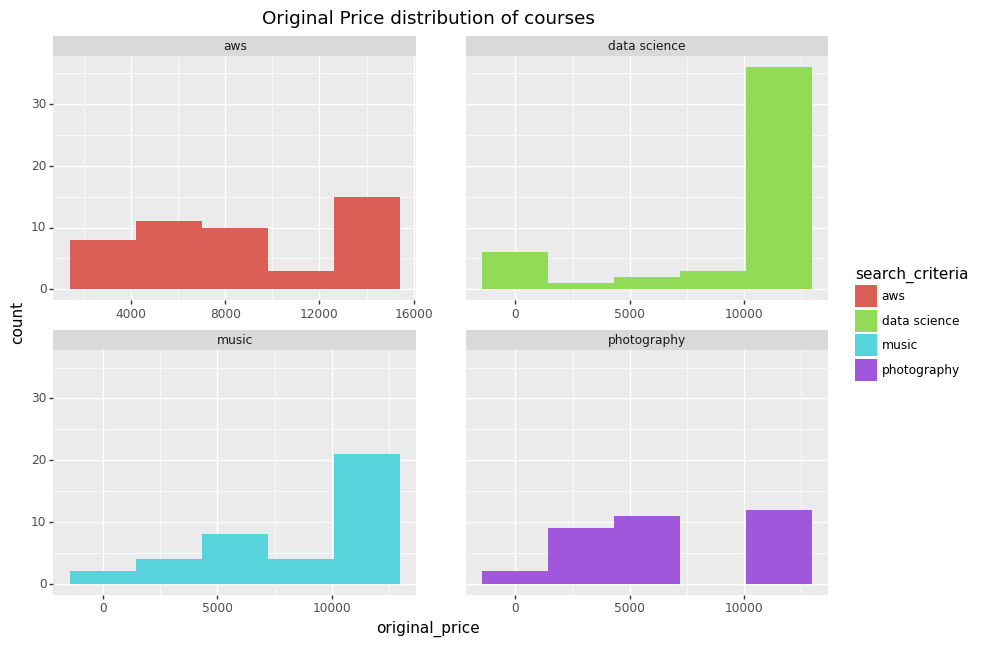

<ggplot: (-9223371889148760872)>

In [21]:
(ggplot(data=df)
+ aes(x='original_price',fill='search_criteria')
+ geom_histogram()
+ facet_wrap('search_criteria',scales='free_x')
+ ggtitle('Original Price distribution of courses')
+ theme(figure_size=(10,7), panel_spacing_y=0.3, panel_spacing_x=0.5)
)

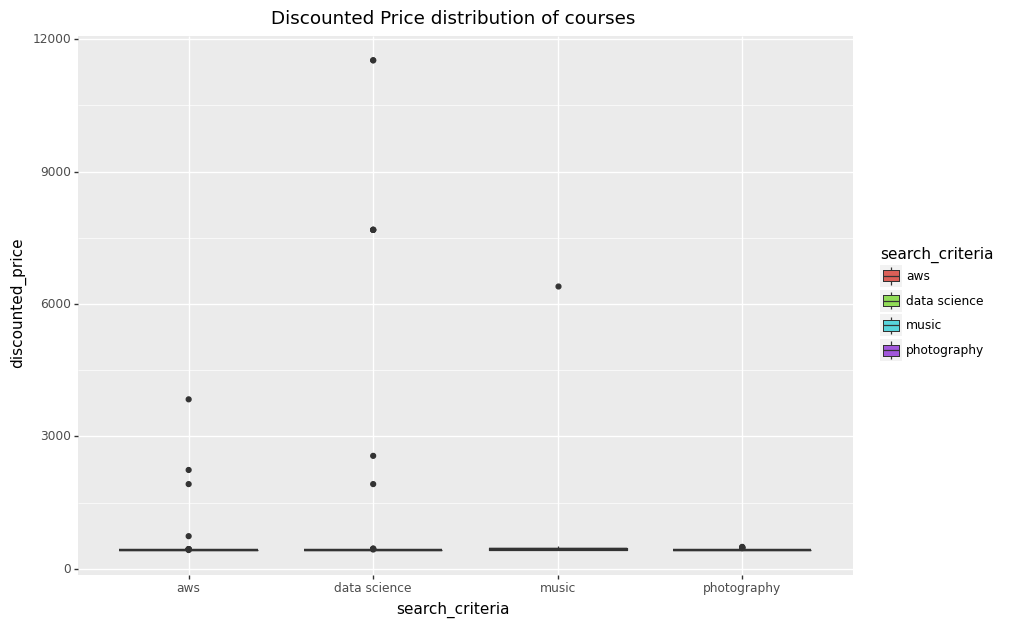

<ggplot: (-9223371889148008812)>

In [22]:
(ggplot(data=df)
+ aes(x='search_criteria',y='discounted_price', fill='search_criteria')
+ geom_boxplot()
+ scale_y_continuous()
# + facet_wrap('search_criteria',scales='free')
+ ggtitle('Discounted Price distribution of courses')
+ theme(figure_size=(10,7), panel_spacing_y=0.3, panel_spacing_x=0.5)
)

## View relationship of price with duration and number of lectures

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_jitter : Removed 33 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


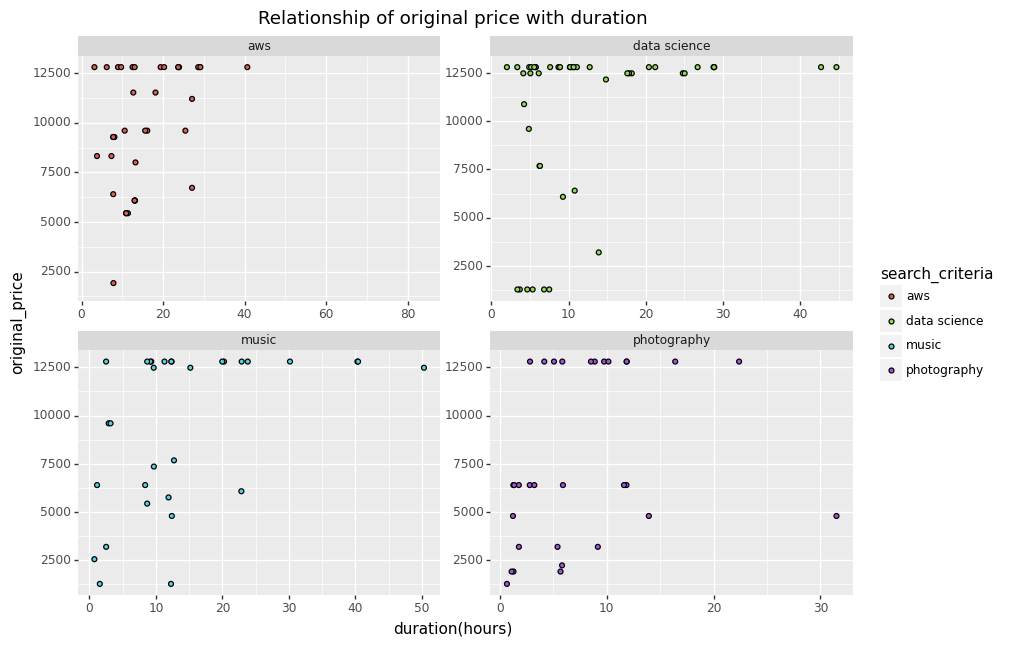

<ggplot: (-9223371889147994360)>

In [23]:
(ggplot(data=df)
+ aes(x='duration',y='original_price',fill='search_criteria')
+ geom_jitter()
+ facet_wrap('search_criteria',scales='free')
+ ggtitle('Relationship of original price with duration')
+ theme(figure_size=(10,7), panel_spacing_y=0.3, panel_spacing_x=0.5)
+ labs(x='duration(hours)')
)

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_jitter : Removed 27 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


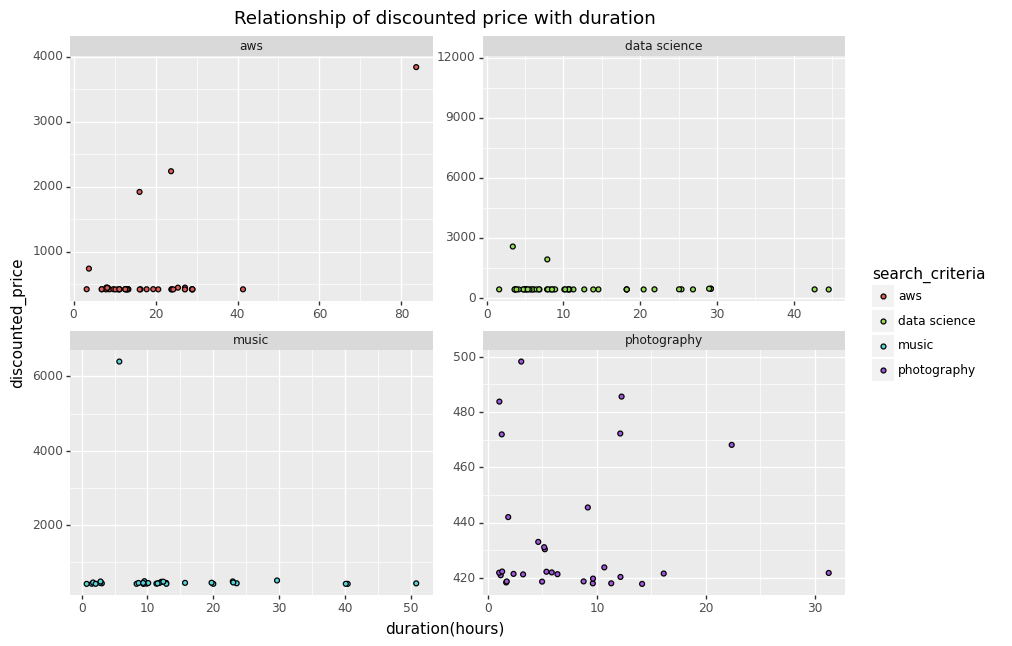

<ggplot: (-9223371889148409372)>

In [24]:
(ggplot(data=df)
+ aes(x='duration',y='discounted_price',fill='search_criteria')
+ geom_jitter()
+ facet_wrap('search_criteria',scales='free')
+ ggtitle('Relationship of discounted price with duration')
+ theme(figure_size=(10,7), panel_spacing_y=0.3, panel_spacing_x=0.5)
+ labs(x='duration(hours)')
)

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_jitter : Removed 26 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


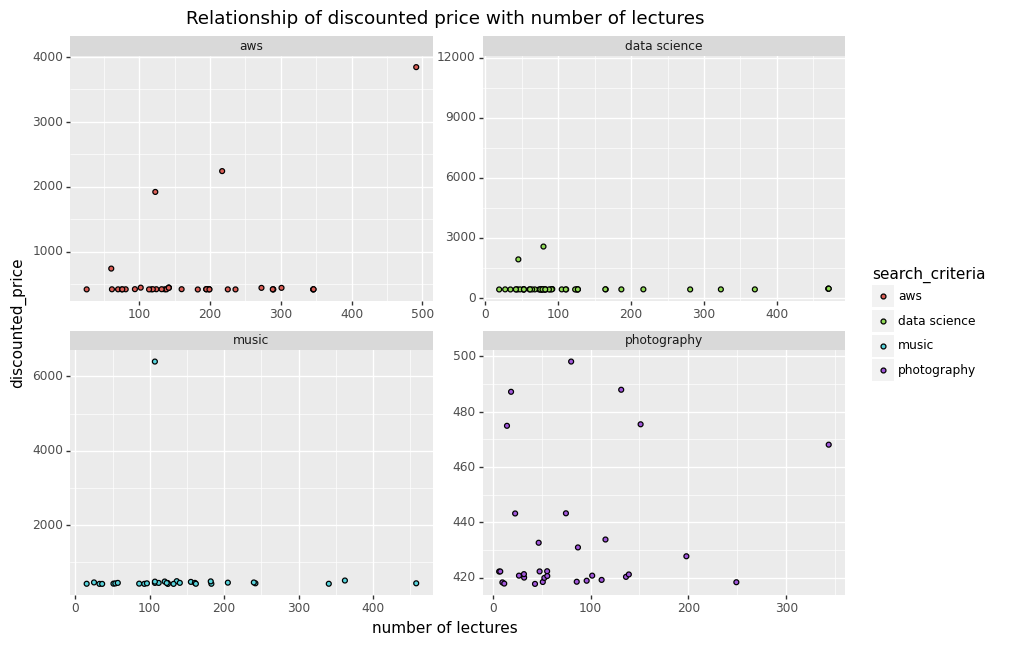

<ggplot: (-9223371889150294956)>

In [25]:
(ggplot(data=df)
+ aes(x='lectures',y='discounted_price',fill='search_criteria')
+ geom_jitter()
+ facet_wrap('search_criteria',scales='free')
+ ggtitle('Relationship of discounted price with number of lectures')
+ theme(figure_size=(10,7), panel_spacing_y=0.3, panel_spacing_x=0.5)
+ labs(x='number of lectures')
)

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_jitter : Removed 32 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


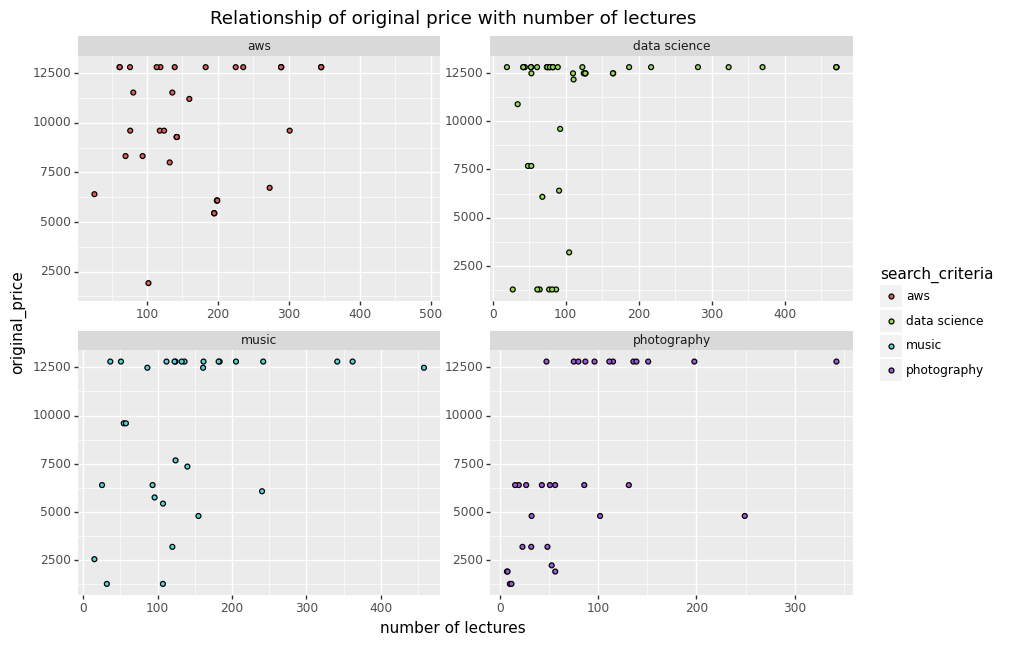

<ggplot: (-9223371889150338404)>

In [26]:
(ggplot(data=df)
+ aes(x='lectures',y='original_price',fill='search_criteria')
+ geom_jitter()
+ facet_wrap('search_criteria',scales='free')
+ ggtitle('Relationship of original price with number of lectures')
+ theme(figure_size=(10,7), panel_spacing_y=0.3, panel_spacing_x=0.5)
+ labs(x='number of lectures')
)